# Simple Transformer 數字排序模型
這個 Notebook 展示如何使用 Transformer 模型學習對數字進行排序。

## 背景知識
- **Transformer** 是一種基於自注意力機制（Self-Attention）的深度學習架構
- 原始論文：《Attention Is All You Need》(2017)
- 本範例任務：輸入一組數字，模型學習輸出排序後的結果

## 1. 導入套件

In [10]:
import torch              # PyTorch 主套件，提供張量運算和自動微分
import torch.nn as nn     # 神經網路模組，包含各種層和損失函數
import torch.optim as optim  # 優化器模組，包含 SGD、Adam 等

# 檢查是否有 GPU 可用
# torch.cuda.is_available() 返回 True 如果有 NVIDIA GPU 且安裝了 CUDA
# 如果有 GPU 就用 GPU（cuda），否則用 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用裝置: {device}")

使用裝置: cpu


## 2. 定義模型 (Simple Transformer)

### 模型架構說明
```
輸入序列 → Embedding → Transformer (Encoder + Decoder) → Linear → 輸出序列
```

### 參數說明
- `vocab_size`: 詞彙表大小（本例中為 0-11 共 12 個數字）
- `d_model`: 嵌入維度，每個 token 被轉換成的向量長度
- `nhead`: 多頭注意力的頭數
- `num_layers`: Encoder 和 Decoder 各有幾層

In [11]:
class SimpleTransformer(nn.Module):
    """
    簡單的 Transformer 模型，用於序列到序列的任務（如排序）
    繼承自 nn.Module，這是所有 PyTorch 神經網路的基類
    """
    
    def __init__(self, vocab_size, d_model, nhead, num_layers):
        """
        初始化模型
        
        參數:
            vocab_size (int): 詞彙表大小，決定 embedding 層的輸入維度
            d_model (int): 模型的隱藏維度，所有層的輸出都是這個維度
            nhead (int): 多頭注意力的頭數，d_model 必須能被 nhead 整除
            num_layers (int): Encoder 和 Decoder 的層數
        """
        super(SimpleTransformer, self).__init__()  # 調用父類的初始化方法
        
        self.d_model = d_model  # 保存維度，forward 時需要用到
        
        # Embedding 層：將整數索引轉換為稠密向量
        # 輸入: (*, ) 的整數張量，值範圍 [0, vocab_size-1]
        # 輸出: (*, d_model) 的浮點張量
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # Transformer 核心模組
        # 包含 num_layers 個 Encoder 層和 num_layers 個 Decoder 層
        self.transformer = nn.Transformer(
            d_model=d_model,           # 輸入/輸出的特徵維度
            nhead=nhead,               # 多頭注意力的頭數
            num_encoder_layers=num_layers,  # Encoder 堆疊層數
            num_decoder_layers=num_layers,  # Decoder 堆疊層數
            dropout=0.1                # Dropout 比率，防止過擬合
        )
        
        # 全連接輸出層：將 d_model 維度映射回 vocab_size
        # 輸出的每個位置是一個 vocab_size 維的向量，表示各詞彙的機率分布
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src, trg, tgt_mask=None):
        """
        前向傳播
        
        參數:
            src: 源序列（Encoder 輸入），維度 (Seq_Len, Batch)
            trg: 目標序列（Decoder 輸入），維度 (Seq_Len, Batch)
            tgt_mask: Decoder 的遮罩，防止看到未來的 token
            
        返回:
            output: 預測的機率分布，維度 (Seq_Len, Batch, vocab_size)
        """
        # 步驟 1: 將整數 token 轉換為嵌入向量
        # src: (Seq, Batch) -> src_emb: (Seq, Batch, d_model)
        src_emb = self.embedding(src) * (self.d_model ** 0.5)
        trg_emb = self.embedding(trg) * (self.d_model ** 0.5)
        # 乘以 sqrt(d_model) 是論文中的縮放技巧
        # 目的：讓 embedding 的值與 positional encoding 在相似的數值範圍
        
        # 步驟 2: 通過 Transformer 進行計算
        # Encoder 處理 src_emb，Decoder 處理 trg_emb 並參考 Encoder 輸出
        # tgt_mask 確保 Decoder 在預測位置 i 時只能看到位置 0 到 i-1
        out = self.transformer(src_emb, trg_emb, tgt_mask=tgt_mask)
        # out: (Seq_Len, Batch, d_model)
        
        # 步驟 3: 線性層將隱藏狀態映射到詞彙表大小
        return self.fc_out(out)
        # 輸出: (Seq_Len, Batch, vocab_size)

## 3. 數據生成函數 (數字排序)

### 任務說明
- **輸入 (src)**: 隨機的數字序列，如 `[8, 2, 5, 1, 9]`
- **輸出 (target)**: 排序後的序列，如 `[1, 2, 5, 8, 9]`

### Teacher Forcing
訓練時，Decoder 的輸入是「正確答案向右移一位」：
- 目標: `[1, 2, 5, 8, 9]`
- Decoder 輸入: `[<SOS>, 1, 2, 5, 8]`（開頭加 SOS，去掉最後一個）

這樣 Decoder 在預測位置 i 時，輸入是位置 0 到 i-1 的正確答案。

In [12]:
def generate_data(batch_size, length=5):
    """
    生成訓練數據：隨機數字序列及其排序結果
    
    參數:
        batch_size (int): 批次大小，一次生成多少組數據
        length (int): 序列長度，每組數據有幾個數字
        
    返回:
        src: Encoder 輸入，維度 (Seq_Len, Batch)
        trg_input: Decoder 輸入，維度 (Seq_Len, Batch)
        target: 目標輸出（標籤），維度 (Seq_Len, Batch)
    """
    # 生成隨機數字，範圍 1-10
    # 0 保留給 <SOS>（Start Of Sequence）特殊 token
    # torch.randint(low, high, size): 生成 [low, high) 的隨機整數
    src = torch.randint(1, 11, (batch_size, length))
    # src 維度: (batch_size, length)，例如 (32, 5)
    
    # 對每個序列進行排序
    # torch.sort 返回 (排序後的值, 原始索引)
    # [0] 取排序後的值
    target = torch.sort(src, dim=1)[0]
    # dim=1 表示沿著第二個維度（序列長度）排序
    # target 維度: (batch_size, length)
    
    # 構建 Decoder 輸入（Teacher Forcing）
    # 創建全零張量作為 <SOS> token
    sos = torch.zeros((batch_size, 1), dtype=torch.long)
    # sos 維度: (batch_size, 1)
    
    # 將 <SOS> 與 target 的前 length-1 個元素拼接
    # target[:, :-1] 取 target 除了最後一個元素的部分
    trg_input = torch.cat([sos, target[:, :-1]], dim=1)
    # 例如: target = [1,2,5,8,9] -> trg_input = [0,1,2,5,8]
    # trg_input 維度: (batch_size, length)
    
    # 轉置為 (Seq_Len, Batch) 格式
    # PyTorch 的 Transformer 預設輸入格式是 (Seq, Batch, Feature)
    # .t() 是 .transpose(0, 1) 的簡寫
    return src.t(), trg_input.t(), target.t()
    # 返回維度都是 (length, batch_size)，例如 (5, 32)

## 4. 參數設置與模型初始化

### 超參數說明
| 參數 | 值 | 說明 |
|------|-----|------|
| VOCAB_SIZE | 12 | 0: SOS, 1-10: 數字, 11: 備用 |
| D_MODEL | 64 | 嵌入維度，較小的模型 |
| NHEAD | 8 | 8 個注意力頭，每頭維度 = 64/8 = 8 |
| NUM_LAYERS | 3 | Encoder/Decoder 各 3 層 |
| BATCH_SIZE | 32 | 每次訓練 32 個樣本 |

In [13]:
# ===== 超參數設置 =====
VOCAB_SIZE = 12   # 詞彙表大小: 0=<SOS>, 1-10=數字, 11=冗餘（未使用）
D_MODEL = 64      # 嵌入維度：每個 token 的向量表示長度
NHEAD = 8         # 多頭注意力頭數：d_model 必須能被 nhead 整除 (64/8=8)
NUM_LAYERS = 3    # Transformer 層數：Encoder 和 Decoder 各 3 層
BATCH_SIZE = 32   # 批次大小：每次訓練用 32 個樣本

# ===== 模型初始化 =====
# 創建模型實例並移動到指定設備（GPU 或 CPU）
model = SimpleTransformer(VOCAB_SIZE, D_MODEL, NHEAD, NUM_LAYERS).to(device)
# .to(device) 將模型的所有參數移動到 GPU（如果可用）

# ===== 優化器設置 =====
# Adam 優化器：自適應學習率的優化算法
# model.parameters() 返回模型所有可訓練參數的迭代器
# lr=0.0005 是學習率，控制每次參數更新的步長
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# ===== 損失函數設置 =====
# CrossEntropyLoss：交叉熵損失，適用於多分類問題
# 內部會先做 softmax，然後計算負對數似然
criterion = nn.CrossEntropyLoss()

# ===== 統計模型參數量 =====
# p.numel() 返回張量中元素的總數
# sum(...) 對所有參數的元素數求和
total_params = sum(p.numel() for p in model.parameters())
print(f"模型參數數量: {total_params}")
# 這個數字反映模型的大小和複雜度

模型參數數量: 1739020


c:\Users\USER\anaconda3\envs\FX\lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## 5. 訓練模型

### 訓練流程
1. **生成數據**: 每個 epoch 生成新的隨機數據
2. **前向傳播**: 輸入數據，計算模型輸出
3. **計算損失**: 比較輸出和目標的差異
4. **反向傳播**: 計算梯度
5. **更新參數**: 優化器根據梯度更新模型參數

### 遮罩 (Mask) 的作用
Decoder 遮罩確保模型在預測第 i 個位置時，只能看到第 0 到 i-1 個位置的資訊，防止「作弊」。

In [14]:
print("開始訓練...")

# 將模型設置為訓練模式
# 這會啟用 Dropout 等只在訓練時使用的層
model.train()

# 用於記錄每個 epoch 的損失值，之後繪圖用
losses = []

# 訓練迴圈：執行 2001 次迭代（epoch 0 到 2000）
for epoch in range(2001):
    
    # ===== 步驟 1: 生成訓練數據 =====
    # 每次迭代都生成新的隨機數據，增加數據多樣性
    src, trg_input, trg_expected = generate_data(BATCH_SIZE)
    # src: 原始序列 (5, 32)
    # trg_input: Decoder 輸入 (5, 32)
    # trg_expected: 目標輸出 (5, 32)
    
    # 將數據移動到指定設備
    src = src.to(device)
    trg_input = trg_input.to(device)
    trg_expected = trg_expected.to(device)
    
    # ===== 步驟 2: 生成 Decoder 遮罩 =====
    # 這個遮罩是一個上三角矩陣，用來防止 Decoder 看到未來的 token
    # 矩陣中 -inf 的位置會在 softmax 後變成 0（不關注）
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(
        trg_input.size(0)  # 序列長度，這裡是 5
    ).to(device)
    # tgt_mask 維度: (5, 5)
    # 形如:
    # [[0, -inf, -inf, -inf, -inf],
    #  [0,    0, -inf, -inf, -inf],
    #  [0,    0,    0, -inf, -inf],
    #  [0,    0,    0,    0, -inf],
    #  [0,    0,    0,    0,    0]]
    
    # ===== 步驟 3: 清零梯度 =====
    # PyTorch 默認會累積梯度，所以每次迭代前要清零
    optimizer.zero_grad()
    
    # ===== 步驟 4: 前向傳播 =====
    # 將數據輸入模型，得到預測輸出
    output = model(src, trg_input, tgt_mask=tgt_mask)
    # output 維度: (5, 32, 12) = (Seq_Len, Batch, Vocab_Size)
    
    # ===== 步驟 5: 計算損失 =====
    # CrossEntropyLoss 需要的格式:
    # - 輸入: (N, C) 其中 N 是樣本數，C 是類別數
    # - 目標: (N,) 整數標籤
    # 因此需要將 output 和 target 展平
    loss = criterion(
        output.view(-1, VOCAB_SIZE),    # (5*32, 12) = (160, 12)
        trg_expected.reshape(-1)        # (5*32,) = (160,)
    )
    
    # ===== 步驟 6: 反向傳播 =====
    # 計算損失對所有參數的梯度
    loss.backward()
    
    # ===== 步驟 7: 更新參數 =====
    # 優化器根據梯度更新模型參數
    optimizer.step()
    
    # 記錄損失值
    losses.append(loss.item())  # .item() 將單元素張量轉為 Python 數字
    
    # 每 500 個 epoch 打印一次進度
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

print("訓練完成!")

開始訓練...
Epoch 0, Loss: 2.6865
Epoch 500, Loss: 0.1187
Epoch 1000, Loss: 0.0757
Epoch 1500, Loss: 0.0089
Epoch 2000, Loss: 0.0502
訓練完成!


## 6. 視覺化訓練損失

損失曲線可以幫助我們了解：
- 模型是否在學習（損失下降）
- 是否收斂（損失趨於穩定）
- 是否過擬合（訓練損失持續下降但驗證損失上升）

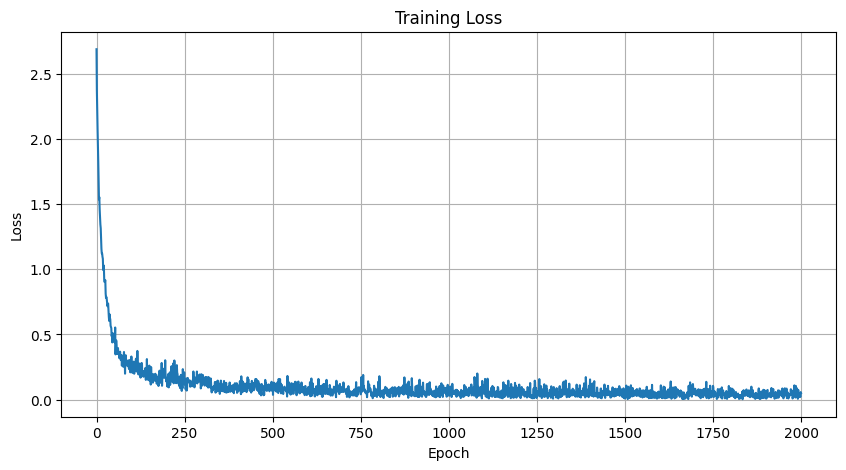

In [15]:
# 導入繪圖庫
import matplotlib.pyplot as plt

# 創建一個 10x5 英寸的圖形
plt.figure(figsize=(10, 5))

# 繪製損失曲線
# losses 是一個列表，包含每個 epoch 的損失值
plt.plot(losses)
# 預設 x 軸是索引（0, 1, 2, ...），y 軸是損失值

# 設置圖表標題
plt.title('Training Loss')

# 設置 x 軸標籤
plt.xlabel('Epoch')

# 設置 y 軸標籤
plt.ylabel('Loss')

# 添加網格線，方便讀取數值
plt.grid(True)

# 顯示圖形
plt.show()
# 在 Jupyter Notebook 中會直接顯示在 cell 輸出區域

## 7. 推理函數

### 推理 vs 訓練的差異
| | 訓練 | 推理 |
|---|---|---|
| Decoder 輸入 | 真實答案（Teacher Forcing） | 模型自己的預測 |
| 生成方式 | 一次生成所有位置 | 逐步生成（自回歸） |
| 模式 | `model.train()` | `model.eval()` |

### 自回歸生成流程
1. 輸入 `<SOS>` token
2. 預測第一個輸出 token
3. 將預測結果加入 Decoder 輸入
4. 重複直到生成完整序列

In [16]:
def evaluate(model, input_seq):
    """
    使用訓練好的模型進行推理（預測）
    
    參數:
        model: 訓練好的 SimpleTransformer 模型
        input_seq: 輸入序列，如 [8, 2, 5, 1, 9]
        
    返回:
        預測的排序結果，如 [1, 2, 5, 8, 9]
    """
    # 設置為評估模式
    # 這會關閉 Dropout，使用訓練時的 BatchNorm 統計量
    model.eval()
    
    # 關閉梯度計算
    # 推理時不需要計算梯度，可以節省記憶體和加速
    with torch.no_grad():
        
        # ===== 準備 Encoder 輸入 =====
        # 將 Python 列表轉換為 PyTorch 張量
        # unsqueeze(1) 在第 1 維增加一個維度，從 (5,) 變成 (5, 1)
        # 這樣符合 (Seq_Len, Batch) 的格式
        src = torch.tensor(input_seq).unsqueeze(1).to(device)
        # src 維度: (5, 1)
        
        # ===== 初始化 Decoder 輸入 =====
        # 只有 <SOS> token（值為 0）
        trg_input = torch.tensor([[0]]).to(device)
        # trg_input 維度: (1, 1) = (Seq_Len=1, Batch=1)
        
        # ===== 自回歸生成迴圈 =====
        # 每次生成一個 token，總共生成 len(input_seq) 個
        for _ in range(len(input_seq)):
            
            # 生成當前長度的 Decoder 遮罩
            # 隨著 trg_input 增長，遮罩也要相應變大
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(
                trg_input.size(0)  # 當前 Decoder 輸入長度
            ).to(device)
            
            # 前向傳播，得到預測
            out = model(src, trg_input, tgt_mask=tgt_mask)
            # out 維度: (當前長度, 1, 12)
            
            # 取最後一個時間步的預測
            # out[-1, :] 取最後一個時間步，維度 (1, 12)
            # argmax(dim=-1) 找出機率最大的類別索引
            # .item() 將單元素張量轉為 Python 整數
            next_word = out.argmax(dim=-1)[-1, :].item()
            
            # 將預測的 token 添加到 Decoder 輸入末尾
            # 這樣下一次迭代會基於之前所有的預測
            next_word_tensor = torch.tensor([[next_word]]).to(device)
            trg_input = torch.cat([trg_input, next_word_tensor], dim=0)
            # trg_input 長度增加 1
        
        # ===== 返回結果 =====
        # trg_input 包含 [<SOS>, pred1, pred2, pred3, pred4, pred5]
        # squeeze() 移除大小為 1 的維度，(6, 1) -> (6,)
        # tolist() 轉換為 Python 列表
        # [1:] 去掉開頭的 <SOS>，只返回預測的數字
        return trg_input.squeeze().tolist()[1:]

## 8. 測試模型

測試模型是否成功學會了排序任務。我們會用幾個不同的測試案例：
1. 一般隨機序列
2. 已經排好序的序列
3. 包含重複數字的序列

In [17]:
# ===== 單一測試案例 =====

# 定義測試輸入
test_input = [8, 2, 5, 1, 9]

# 使用模型進行預測
predicted = evaluate(model, test_input)

# 計算期望結果（Python 內建排序）
expected = sorted(test_input)

# 打印結果
print(f"測試輸入: {test_input}")
print(f"期望結果: {expected}")
print(f"模型排序結果: {predicted}")

# 檢查是否正確
# 直接比較兩個列表是否相等
print(f"是否正確: {predicted == expected}")

測試輸入: [8, 2, 5, 1, 9]
期望結果: [1, 2, 5, 8, 9]
模型排序結果: [1, 2, 5, 8, 9]
是否正確: True


In [18]:
# ===== 多個測試案例 =====

# 定義多個測試輸入，涵蓋不同情況
test_cases = [
    [3, 7, 1, 9, 4],     # 一般隨機序列
    [10, 5, 2, 8, 6],    # 包含最大值 10
    [1, 2, 3, 4, 5],     # 已經排好序（測試是否會破壞）
    [5, 5, 5, 5, 5]      # 全部相同（測試重複處理）
]

# 對每個測試案例進行評估
for test in test_cases:
    # 模型預測
    pred = evaluate(model, test)
    
    # 期望結果
    exp = sorted(test)
    
    # 判斷正確性並選擇顯示符號
    # ✓ 表示正確，✗ 表示錯誤
    status = "✓" if pred == exp else "✗"
    
    # 格式化輸出
    print(f"{status} 輸入: {test} -> 預測: {pred} (期望: {exp})")

✓ 輸入: [3, 7, 1, 9, 4] -> 預測: [1, 3, 4, 7, 9] (期望: [1, 3, 4, 7, 9])
✓ 輸入: [10, 5, 2, 8, 6] -> 預測: [2, 5, 6, 8, 10] (期望: [2, 5, 6, 8, 10])
✓ 輸入: [1, 2, 3, 4, 5] -> 預測: [1, 2, 3, 4, 5] (期望: [1, 2, 3, 4, 5])
✓ 輸入: [5, 5, 5, 5, 5] -> 預測: [5, 5, 5, 5, 5] (期望: [5, 5, 5, 5, 5])
